In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyntcloud import PyntCloud
import numpy as np
import tensorflow as tf
import os, random

In [162]:
def rotationmat(heading_angle):
    rotmat = np.zeros((3,3))
    rotmat[2,2] = 1
    cosval = np.cos(heading_angle)
    sinval = np.sin(heading_angle)
    rotmat[0:2,0:2] = np.array([[cosval, -sinval],[sinval, cosval]])
    return rotmat

def local_coord(scale):
    w = scale[0] / 2.
    h = scale[1] / 2.
    d = scale[2] / 2.

    # Define the local coordinate system, w.r.t. the center of the box
    box_coords = np.array([[0., 0., 0.], [-w, -h, -d], [-w, -h, +d], [-w, +h, -d],
                     [-w, +h, +d], [+w, -h, -d], [+w, -h, +d], [+w, +h, -d],
                     [+w, +h, +d]])
    return box_coords

def get_vertices(box_points):
    """Calculate vertices of 3d bounding box
    Args:
        box_points: (size 7 numpy array): xyz pos of center and 3 lengths (dx,dy,dz)
            and heading angle around Y axis.
            Z forward, X rightward, Y downward. heading angle of positive X is 0,
            heading angle of negative Z is 90 degrees.
    Output: vertices (9x3 numpy array)
    """
    # scale a unit box
    local_coords = np.transpose(local_coord(box_points[3:6]))
    rotmat = rotationmat(box_points[6])
#     rotmat = rotationmat(90)
    vertices = np.dot(rotmat, local_coords)
    
    # translation using center points
    vertices[0,:] = vertices[0,:] + box_points[0];
    vertices[1,:] = vertices[1,:] + box_points[1];
    vertices[2,:] = vertices[2,:] + box_points[2];
    vertices = np.transpose(vertices)   
        
    return vertices

In [163]:
# load the 3d-box points of objects in image
scene = 'scene0013_00/'
path = 'scannet/votenet_files/scannet_train_detection_data/'
box_coords= np.loadtxt(os.path.join(path,scene,'box_coords.txt'))

In [164]:
# calculate 3d-vertices of objects in image
num_objects, NUM_KEYPOINTS, coords = box_coords.shape[0],9,3
vertices = np.zeros((num_objects,NUM_KEYPOINTS,coords))
for i in range(num_objects):
    vertices[i,:,:] = get_vertices(box_coords[i])

In [176]:
from __future__ import division

path = os.path.join('scannet/scans',scene,'pose')
base_dir= os.path.dirname(path)
poses=os.listdir(path)

def convert2camera_coords(box_vertices, extrinsic_matrix):
    """Calculate camera coords of the 3d box
    Args:
        box_vertices: (3-dimensional array) vertices of all objects in the 3d reconstruction
        extrinsic_matrix: (4x4 array): camera extrinsic parameters
    Output: camera coordinate (3-dimensional array) of all objects
    """
    
    homogenous_vertices = []
    # convert vertices to homogenous coords
    for vert in box_vertices:
        homogenous_vertices.append(np.c_[vert,np.ones(NUM_KEYPOINTS)])
    homogenous_vertices = np.transpose(homogenous_vertices,(0,2,1))
    
    # convert to 2d camera co-ordinates
    camera_coords = np.zeros(homogenous_vertices.shape)
    for i in range(num_objects):
        camera_coords[i]=extrinsic_matrix.dot(homogenous_vertices[i])
        
    return np.transpose(camera_coords,(0,2,1))

def convert2pixel_coords(camera_coordinates, intrinsic_matrix):
    """Calculate pixel coords of the 3d box
    Args:
        camera_coordinates: (3-dimensional array) camera coords of all objects in the 3d reconstruction
        intrinsic_matrix: (4x4 array): camera intrinsic parameters
    Output: pixel coordinate (3-dimensional array) of all objects
    """
    
    camera_coordinates = np.transpose(camera_coordinates,(0,2,1))
    pixel_coords = np.zeros(camera_coordinates.shape)
    for i in range(num_objects):
        pixel_coords[i]=intrinsic_matrix.dot(camera_coordinates[i])   
        # project 3d points to 2d
        pixel_coords[i,:3,:]=pixel_coords[i,:3,:]/ pixel_coords[i,2,:]
        
    return np.transpose(pixel_coords,(0,2,1))

camera_pose=np.loadtxt(os.path.join(path,poses[20]))
camera_coords=convert2camera_coords(vertices, camera_pose)
intrinsic_matrix=np.loadtxt(os.path.join(base_dir,'intrinsic_color.txt'))
pixel_coords=convert2pixel_coords(camera_coords, intrinsic_matrix)

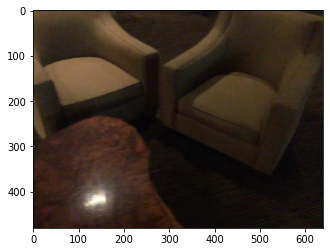

In [184]:
# plot color image
color_raw=mpimg.imread(os.path.join(base_dir,'color',poses[20][:-3]+'jpg'))
plt.imshow(color_raw)
# plt.plot((100, 400), (400, 400), '-')
plt.show()

In [211]:
# plot the bounding boxes
def plotbox(vertices2d):
    EDGES = (
    [1, 5], [2, 6], [3, 7], [4, 8],  # lines along x-axis
    [1, 3], [5, 7], [2, 4], [6, 8],  # lines along y-axis
    [1, 2], [3, 4], [5, 6], [7, 8]   # lines along z-axis
    )
    
    for edge in EDGES:
        j,k = edge[0],edge[1]
        plt.plot((vertices2d[j,0],vertices2d[j,1]), (vertices2d[k,0],vertices2d[k,1]), '-') 

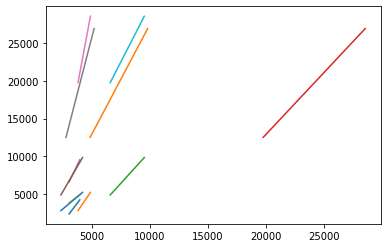

In [214]:
plotbox(pixel_coords[0])
plt.show()